In [133]:
from __future__ import division
from __future__ import print_function

from builtins import str
from builtins import range
from past.utils import old_div

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:       
    print('Not IPYTHON')    
    pass

# Import the usual suspects
import sys
import numpy as np
from time import time
from scipy.sparse import coo_matrix
import psutil
import glob
import os
import scipy
from ipyparallel import Client
import matplotlib as mpl
import pylab as pl
pl.ion()
from IPython.display import clear_output

# Import the relevant files from CaImAn
import caiman as cm
from caiman.components_evaluation import evaluate_components
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
from caiman.base.rois import extract_binary_masks_blob
import caiman.source_extraction.cnmf as cnmf

# Import bokeh - for doing interactive plotting on our components later
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Start the IPyParallel Cluster

In [134]:
n_processes = np.maximum(np.int(psutil.cpu_count()),1) # roughly number of cores on your machine minus 1
print(('using ' + str(n_processes) + ' processes'))

single_thread=False

if single_thread:
    dview=None
else:    
    try:
        c.close()
    except:
        print('C was not existing, creating one')
        
    print("Stopping  cluster to avoid unnencessary use of memory....")
    sys.stdout.flush()  

    cm.stop_server()
    cm.start_server()        
    c=Client()


    print(('Using '+ str(len(c)) + ' processes'))
    dview=c[:len(c)]

using 12 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
............Using 12 processes


# Load all the tiff Files Into a Single Memory Mappable File

In [135]:
base_name = '170201OM421'
base_folder = '/home/absplab/Desktop/datasets/170201OM421'
force_remap = True

subwindow = (slice(0,1024), slice(0,1024)) # set to None for the full window
downsample_factor = 1 # use .2 or .1 if file is large and you want a quick answer
remove_init = 0

# check if there aren't already mapped files in the directory
pre_mapped_files = [os.path.abspath(file) for file in glob.glob(os.path.join(base_folder,base_name +'_*'))]

# if there were and we're don't want to repl170201OM421ace them, just take the first file name matching 'Yr_' as the memmap name
if len(pre_mapped_files) and not force_remap:
    
    mmap_file_name = pre_mapped_files[0]
    print('Using premapped file of name: ' + mmap_file_name)
    print('Set force_remap to True to refresh this file')

# otherwise we fish out all the tif files in the directory and pass them to save_memmap_each 
# for memmapping and then join them into a single file with save_memmap_join
else:
    print('Remapping was forced or no memmapped file could be found, remapping...')

    tif_files = [os.path.abspath(file) for file in glob.glob(os.path.join(base_folder,'*.tif'))]

    if len(tif_files) == 0:
        raise Exception("No tif files were found in the specified directory")

    tif_files.sort()

    mmap_files = cm.save_memmap_each(tif_files, dview=dview, base_name=base_name, resize_fact=(1, 1, downsample_factor), remove_init=remove_init, idx_xy=subwindow)
    mmap_files.sort()
    mmap_file_name = cm.save_memmap_join(mmap_files, base_name=base_name, n_chunks=12, dview=dview)

    print('Using memmap file of name: ' + mmap_file_name)

Remapping was forced or no memmapped file could be found, remapping...
('/home/absplab/Desktop/datasets/170201OM421/170201OM4210000_d1_1024_d2_1024_d3_1_order_C_frames_1500_.mmap', 1500)
('/home/absplab/Desktop/datasets/170201OM421/170201OM4210001_d1_1024_d2_1024_d3_1_order_C_frames_1500_.mmap', 1500)
/home/absplab/Desktop/datasets/170201OM421/170201OM421_d1_1024_d2_1024_d3_1_order_C_frames_3000_.mmap
Deleting big mov
Using memmap file of name: /home/absplab/Desktop/datasets/170201OM421/170201OM421_d1_1024_d2_1024_d3_1_order_C_frames_3000_.mmap


In [136]:
Yr, Y = [], []
Yr, dims, T = cm.load_memmap(mmap_file_name)
Y = np.reshape(Yr, dims+(T,), order='F')

# Visualise the Correlation Image

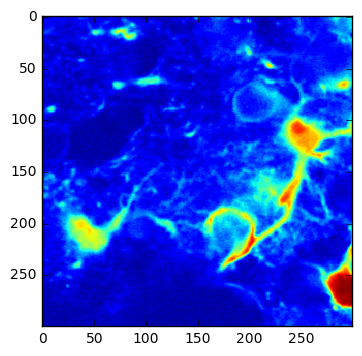

In [15]:
Cn = cm.local_correlations(Y)
pl.imshow(Cn,cmap='jet',interpolation='none')

# Parameterise the Analysis

In [137]:
# frame rate in Hz
final_frate = 10 

# half-size of the patches in pixels. rf=128, patches are 256x256
rf = 128

# amount of overlap between the patches in pixels    
stride = 64 

# number of neurons expected per patch
K = 20

# expected half size of neurons
gSig = [10,10] 

# merging threshold, max correlation allowed
merge_thresh = 0.8 

# order of the autoregressive system
p = 2

# unitless number accounting how much memory should be used.
memory_fact = 1

# save filename for results (set to None to skip save)
save_file = 'results_170201OM421.npz'

# populate the 'options' dictionary
options_patch = cnmf.utilities.CNMFSetParms((dims, T), n_processes, p=0, gSig=gSig, K=K, ssub=1, tsub=4, nIter_patch=10, thr=merge_thresh)

using 12 processes
using 1000 pixels per process
using 1000 block_size


# Run the Analysis on the Patches

This divides the FOV up into overlapping patches and runs the CNMF on each. Each spatial component extracted from each patch is projected onto the full field of view and stored as a component in A. As a result, A at this point will be full of lots of overlapping components

In [ ]:
A, C, YrA, b, f, sn, optional_outputs = cnmf.map_reduce.run_CNMF_patches(mmap_file_name, (dims[0], dims[1], T), options_patch, rf=rf, stride=stride, dview=dview, memory_fact=memory_fact, gnb=1)

if save_file is not None:
    np.savez(save_file, A=A.todense(), C=C, sn=sn, b=b, f=f, dims=dims, T=T)

25


# Or Load Results from a Numpy File

In [ ]:
if save_file is not None:
    with np.load(save_file) as res:
        A = scipy.sparse.csr.csr_matrix(res['A'])
        C, sn, b, f, dims, T = res['C'], res['sn'], res['b'], res['f'], res['dims'], res['T']

# Now Reconfigure the Analysis to Look at the Full Window

In [36]:
options_full = cnmf.utilities.CNMFSetParms(Y, n_processes, p=0, gSig=gSig, K=A.shape[-1], thr=merge_thresh)

# regulates the amount of memory used
pixels_per_process = np.minimum(np.int(np.prod(dims)/n_processes/(old_div(T,2000.))), np.int(old_div(np.prod(dims),n_processes)))
options_full['spatial_params']['n_pixels_per_process'] = pixels_per_process
options_full['temporal_params']['n_pixels_per_process'] = pixels_per_process

options_full['temporal_params']['p'] = 0
options_full['temporal_params']['fudge_factor'] = 0.96 #change if denoised traces time constant is wrong
options_full['temporal_params']['backend']='ipyparallel'

using 12 processes
using 1000 pixels per process
using 1000 block_size


# Merge Spatially Overlaping and Temporally Correlated Components

In [37]:
A, C, nr, merged_ROIs, S, bl, c1, sn_merged, g = cnmf.merging.merge_components(Yr,A,[],np.array(C),[],np.array(C),[],options_full['temporal_params'],options_full['spatial_params'],dview=dview,thr=options_full['merging']['thr'],mx=np.Inf)   

[ 6  8 15 20]
[ 7 19]
[0 9]


# Update the Temporal Components to get Yr

In [38]:
C, f, S, bl, c1, neurons_sn, g2, YrA = cnmf.temporal.update_temporal_components(Yr, A, b, C, f, dview=dview, bl=None, c1=None, sn=None, g=None, **options_full['temporal_params'])

Generating residuals
Forcing single thread for memory issues
parallel dot product block size: 1000
Start product
Transposing
Done
1 out of total 16 temporal components updated
2 out of total 16 temporal components updated
5 out of total 16 temporal components updated
16 out of total 16 temporal components updated
1 out of total 16 temporal components updated
3 out of total 16 temporal components updated
5 out of total 16 temporal components updated
16 out of total 16 temporal components updated
stopping: overall temporal component not changing significantly


In [39]:
traces = C + YrA

fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = evaluate_components(Y, traces, A, C, b, f, final_frate=final_frate, remove_baseline=True, N=5, robust_std=False, Athresh=0.1, Npeaks=10, thresh_C=0.3)

# get the ids of the components evaluated to be acceptable
idx_components_r = np.where(r_values >= 0.5)[0]
idx_components_raw = np.where(fitness_raw < -20)[0]        
idx_components_delta = np.where(fitness_delta < -10)[0]   

# gather the components meeting at least one of the criteria into a list
idx_components = np.union1d(np.union1d(idx_components_r, idx_components_raw), idx_components_delta)

# omit all but the good components from the spatial and temporal matrices
A = A[:,idx_components]
C = C[idx_components,:]

print('Retaining {} of {} components'.format(len(idx_components),len(traces)))

Computing event exceptionality delta
Removing Baseline
Computing event exceptionality
Evaluating spatial footprint
Retaining 15 of 16 components


# Update the Spatial Components

In [40]:
A, b, C = cnmf.spatial.update_spatial_components(Yr, C, f, A, sn=sn, dview=dview, **options_full['spatial_params'])

found spatial support for each component
(90000, 15)
Starting Update Spatial Components
Updated Spatial Components
threshold
Computing residuals
parallel dot product block size: 1000
Start product
Filling
Computing A_bas
--- 9.70731186867 seconds ---
Remove temporary file created


# Update the Temporal Components

In [41]:
options_full['temporal_params']['p'] = p
C, f, S, bl, c1,neurons_sn, g21, YrA = cnmf.temporal.update_temporal_components(Yr,A,b,C,f,dview=dview, bl=None,c1=None,sn=None,g=None,**options_full['temporal_params'])

Generating residuals
Forcing single thread for memory issues
parallel dot product block size: 1000
Start product
Transposing
Done
1 out of total 15 temporal components updated
3 out of total 15 temporal components updated
4 out of total 15 temporal components updated
6 out of total 15 temporal components updated
15 out of total 15 temporal components updated
1 out of total 15 temporal components updated
2 out of total 15 temporal components updated
5 out of total 15 temporal components updated
15 out of total 15 temporal components updated
stopping: overall temporal component not changing significantly


# Stop the Server and Remove the Log Files

In [24]:
if not single_thread:
    c.close()
    cm.stop_server()
    
log_files = glob.glob('Yr*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done


# Evaluate the Components

Order the components according to quality and omit those that fall below a certain threshold. We also find which components are nice blob shapes here and store their ids in idx_blobs, failing to be a blob isn't ground to remove the component though

In [42]:
traces = C + YrA

fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = evaluate_components(Y, traces, A, C, b, f, final_frate=final_frate, remove_baseline=True, N=5, robust_std=False, Athresh = 0.1, Npeaks = 10, thresh_C = 0.3)

idx_components_r = np.where(r_values >= 0.6)[0]
idx_components_raw = np.where(fitness_raw < -60)[0]        
idx_components_delta = np.where(fitness_delta < -20)[0]   

min_radius = gSig[0] - 2
masks_ws, idx_blobs, idx_non_blobs = extract_binary_masks_blob(A.tocsc(), min_radius, dims, num_std_threshold=1, minCircularity=0.6, minInertiaRatio=0.2, minConvexity=0.8)

idx_components = np.union1d(np.union1d(idx_components_r, idx_components_raw), idx_components_delta)
idx_blobs = np.intersect1d(idx_components, idx_blobs)
idx_components_bad = np.setdiff1d(list(range(len(traces))), idx_components)

clear_output()

print('Retaining {} of {} components, {} of which are blobs'.format(len(idx_components),len(traces),len(idx_blobs)))

Retaining 12 of 15 components, 1 of which are blobs


# Visualise the Components

In [139]:
_ = nb_view_patches(Yr,A.tocsc().todense()[:,idx_components],C[idx_components,:],b,f,dims[0], dims[1],thr = 0.9,image_neurons=Cn)

KeyboardInterrupt: 

Populating the interactive namespace from numpy and matplotlib


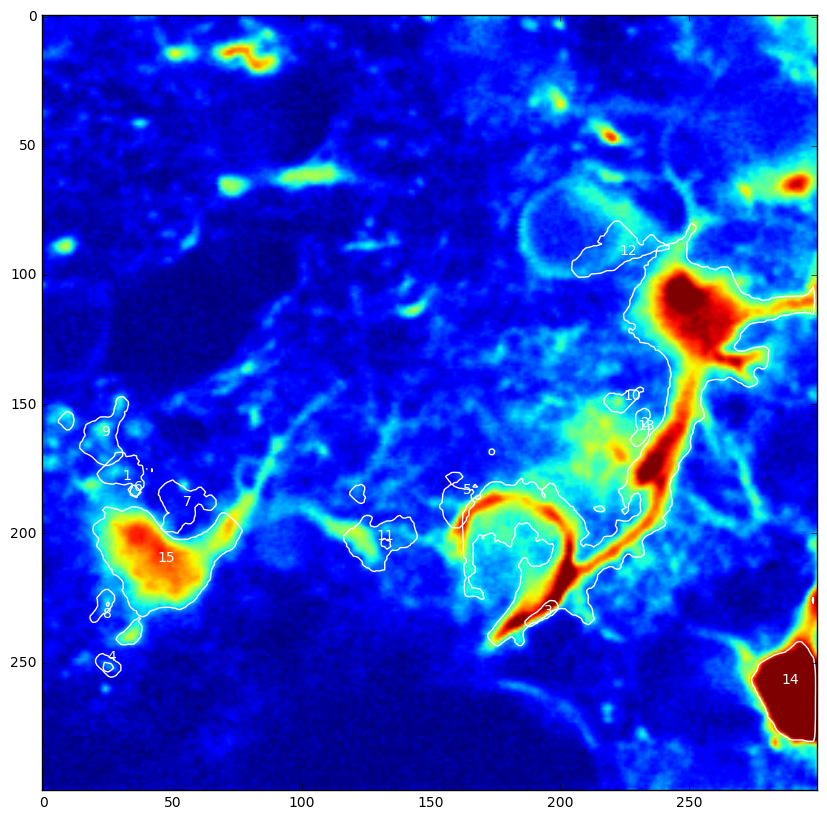

In [90]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

crd = plot_contours(A.tocsc(), Cn, thr=0.9)


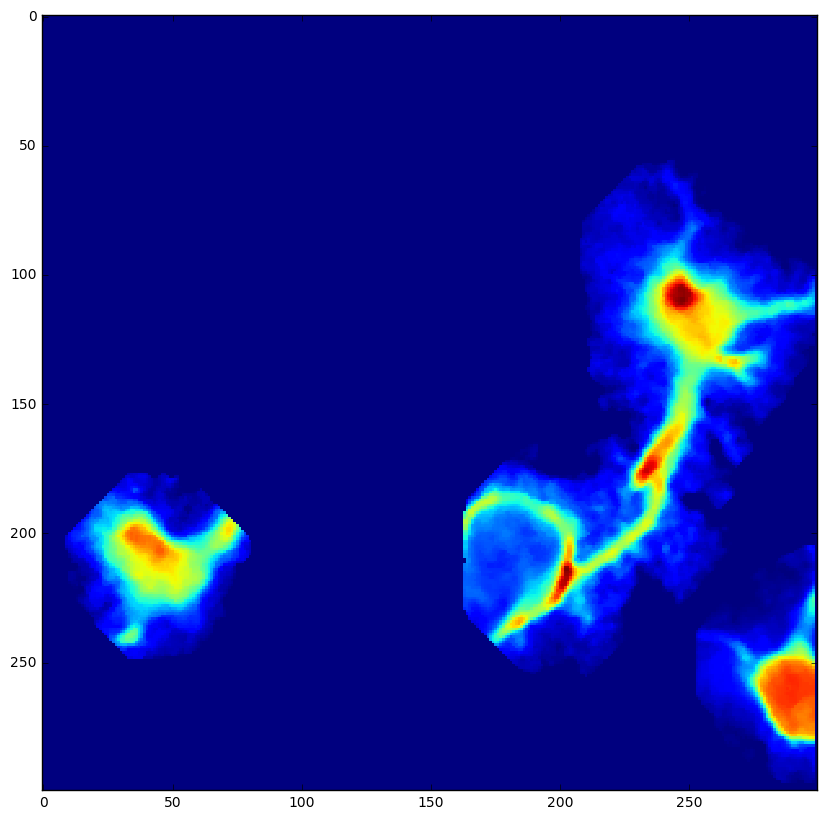

In [129]:
pl.imshow(np.sum(A.todense()[:,12:15],axis=1).reshape(dims).T, interpolation='None')

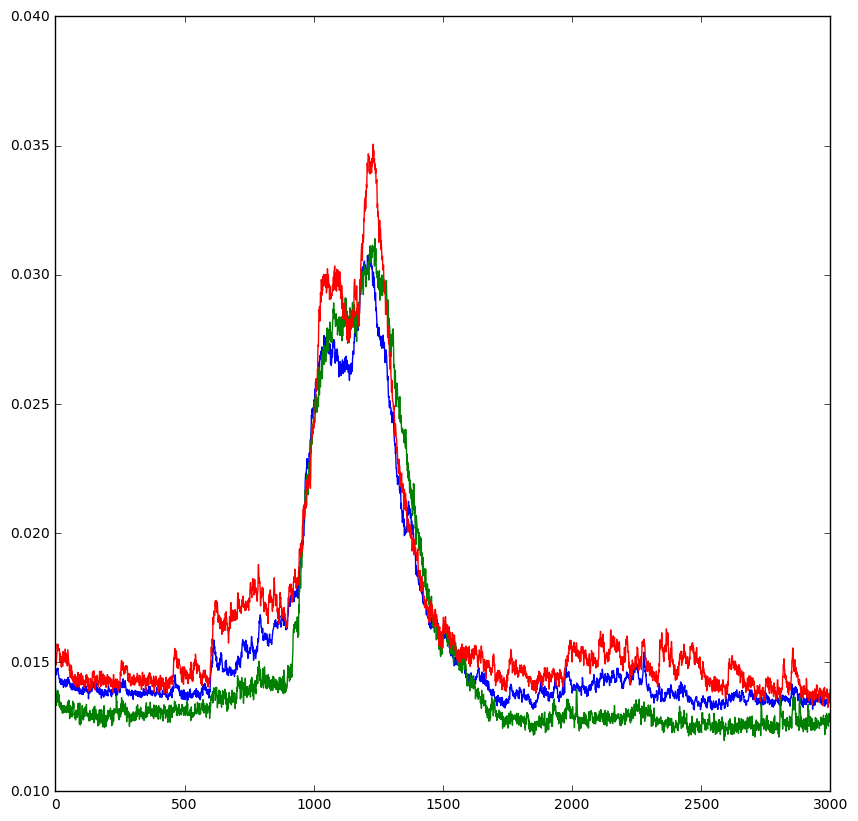

In [132]:
pl.plot(C[12,:],'b',C[13,:],'g',C[14,:],'r')